In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/defi.nurshaleha/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 73


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(759334, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,730401003B1#06,730401003B1,730401003,1,2022_03,6,NP,50MQU,-15.026655,-14.199703,...,-15.914576,-15.166912,-15.157628,-14.478301,-15.180691,7304,1,0.698795,R0C8,0.543411
1,730401005B2#11,730401005B2,730401005,1,2022_03,6,NP,50MQU,-16.516833,-16.747320,...,-17.791132,-15.621688,-13.369461,-15.770675,-15.094735,7304,1,0.812662,R16C16,0.418226
2,730401005B2#13,730401005B2,730401005,1,2022_03,6,NP,50MQU,-17.081285,-16.987770,...,-16.734287,-14.950584,-13.286027,-15.321240,-14.959860,7304,1,0.812662,R16C16,0.418226
3,730401007B1#01,730401007B1,730401007,1,2022_03,2,V2,50MQU,-20.461194,-18.684690,...,-22.450989,-22.957167,-26.829348,-23.570656,-21.312048,7304,1,0.639578,R5C18,0.475817
4,730401007B1#02,730401007B1,730401007,1,2022_03,2,V2,50MQU,-20.795874,-18.227310,...,-20.526600,-22.162128,-26.000465,-23.961231,-21.411504,7304,1,0.639578,R5C18,0.475817


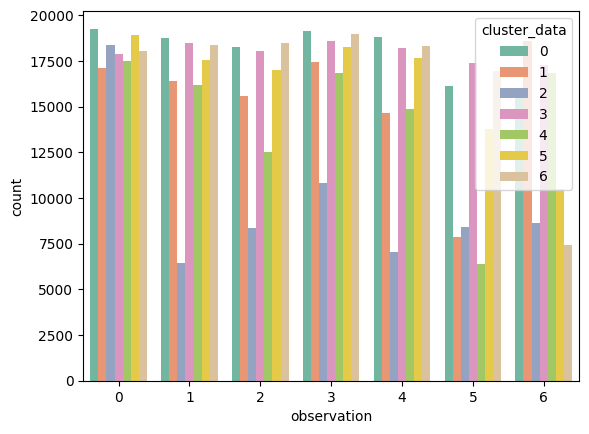

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-23 10:54:55,745] A new study created in memory with name: no-name-74ec41c3-c676-4105-9c9a-4a69d19da90b


[1 2 3 4 0 5 6]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 10:55:36,720] Trial 0 finished with value: 0.9174083056807393 and parameters: {'max_depth': 10, 'learning_rate': 0.043996832508152936, 'reg_lambda': 0.4073485219773061, 'min_child_weight': 51}. Best is trial 0 with value: 0.9174083056807393.


[I 2024-10-23 10:56:06,580] Trial 1 finished with value: 0.9173167873069281 and parameters: {'max_depth': 8, 'learning_rate': 0.07206337332005117, 'reg_lambda': 3.3073042933239623, 'min_child_weight': 77}. Best is trial 0 with value: 0.9174083056807393.


[I 2024-10-23 10:56:29,900] Trial 2 finished with value: 0.9174982483102793 and parameters: {'max_depth': 10, 'learning_rate': 0.09147766283848563, 'reg_lambda': 0.29573088430608907, 'min_child_weight': 54}. Best is trial 2 with value: 0.9174982483102793.


[I 2024-10-23 10:57:39,168] Trial 3 finished with value: 0.9175981285959568 and parameters: {'max_depth': 10, 'learning_rate': 0.02776803516329151, 'reg_lambda': 3.05794793739292, 'min_child_weight': 76}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 10:58:35,845] Trial 4 finished with value: 0.9145029725748812 and parameters: {'max_depth': 6, 'learning_rate': 0.03957031902825333, 'reg_lambda': 1.497483180901955, 'min_child_weight': 72}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 10:59:37,049] Trial 5 finished with value: 0.917288941343026 and parameters: {'max_depth': 9, 'learning_rate': 0.033365370601717306, 'reg_lambda': 2.260827418220665, 'min_child_weight': 89}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 11:00:06,324] Trial 6 finished with value: 0.916273585651545 and parameters: {'max_depth': 8, 'learning_rate': 0.07389298746221129, 'reg_lambda': 2.7191976623228085, 'min_child_weight': 65}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 11:00:35,242] Trial 7 finished with value: 0.9156605351759688 and parameters: {'max_depth': 6, 'learning_rate': 0.08957995932068889, 'reg_lambda': 1.2103286019455606, 'min_child_weight': 63}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 11:01:53,546] Trial 8 finished with value: 0.9172612887899229 and parameters: {'max_depth': 10, 'learning_rate': 0.025950582710970165, 'reg_lambda': 3.6751979987889047, 'min_child_weight': 100}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 11:03:09,322] Trial 9 finished with value: 0.9171905955557303 and parameters: {'max_depth': 9, 'learning_rate': 0.026168629077386582, 'reg_lambda': 2.5237725223536414, 'min_child_weight': 100}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 11:04:21,059] Trial 10 finished with value: 0.9072900055632319 and parameters: {'max_depth': 7, 'learning_rate': 0.011362525293656146, 'reg_lambda': 4.971743431408642, 'min_child_weight': 82}. Best is trial 3 with value: 0.9175981285959568.


[I 2024-10-23 11:04:43,504] Trial 11 finished with value: 0.9176974219431097 and parameters: {'max_depth': 10, 'learning_rate': 0.09667280476665972, 'reg_lambda': 0.2898695977796674, 'min_child_weight': 53}. Best is trial 11 with value: 0.9176974219431097.


[I 2024-10-23 11:05:18,762] Trial 12 finished with value: 0.9168892236032513 and parameters: {'max_depth': 9, 'learning_rate': 0.05878653999671463, 'reg_lambda': 4.27590235502166, 'min_child_weight': 64}. Best is trial 11 with value: 0.9176974219431097.


[I 2024-10-23 11:05:41,230] Trial 13 finished with value: 0.917976294741083 and parameters: {'max_depth': 10, 'learning_rate': 0.09952001372577197, 'reg_lambda': 1.5621648446187248, 'min_child_weight': 86}. Best is trial 13 with value: 0.917976294741083.


[I 2024-10-23 11:06:04,771] Trial 14 finished with value: 0.9173546357494741 and parameters: {'max_depth': 9, 'learning_rate': 0.098799786001639, 'reg_lambda': 1.4008798715685236, 'min_child_weight': 90}. Best is trial 13 with value: 0.917976294741083.


[I 2024-10-23 11:06:34,160] Trial 15 finished with value: 0.917059394762067 and parameters: {'max_depth': 8, 'learning_rate': 0.07742373913184274, 'reg_lambda': 0.8096742254333198, 'min_child_weight': 87}. Best is trial 13 with value: 0.917976294741083.


[I 2024-10-23 11:06:59,651] Trial 16 finished with value: 0.9178763647860316 and parameters: {'max_depth': 10, 'learning_rate': 0.08409232805005323, 'reg_lambda': 1.8819346041335363, 'min_child_weight': 59}. Best is trial 13 with value: 0.917976294741083.


[I 2024-10-23 11:07:26,628] Trial 17 finished with value: 0.9171327862662806 and parameters: {'max_depth': 9, 'learning_rate': 0.08143319542259109, 'reg_lambda': 1.9145946613031963, 'min_child_weight': 70}. Best is trial 13 with value: 0.917976294741083.


[I 2024-10-23 11:08:02,447] Trial 18 finished with value: 0.9166215133158705 and parameters: {'max_depth': 7, 'learning_rate': 0.06233309171967105, 'reg_lambda': 1.9017210119597239, 'min_child_weight': 58}. Best is trial 13 with value: 0.917976294741083.


[I 2024-10-23 11:08:28,140] Trial 19 finished with value: 0.9174343894253716 and parameters: {'max_depth': 10, 'learning_rate': 0.08482360153121989, 'reg_lambda': 1.0085348205482387, 'min_child_weight': 83}. Best is trial 13 with value: 0.917976294741083.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.09952001372577197, 'reg_lambda': 1.5621648446187248, 'min_child_weight': 86}
Best Score: 0.917976294741083
Start the modelling
[0]	train-mlogloss:1.69647	eval-mlogloss:1.70704


[100]	train-mlogloss:0.07587	eval-mlogloss:0.23578


[200]	train-mlogloss:0.03394	eval-mlogloss:0.22332


[300]	train-mlogloss:0.02103	eval-mlogloss:0.22462


[400]	train-mlogloss:0.01536	eval-mlogloss:0.22758


[500]	train-mlogloss:0.01233	eval-mlogloss:0.23033


[600]	train-mlogloss:0.01050	eval-mlogloss:0.23327


[700]	train-mlogloss:0.00925	eval-mlogloss:0.23544


[800]	train-mlogloss:0.00836	eval-mlogloss:0.23751


[900]	train-mlogloss:0.00768	eval-mlogloss:0.23944


[1000]	train-mlogloss:0.00715	eval-mlogloss:0.24117


[1100]	train-mlogloss:0.00672	eval-mlogloss:0.24255


[1200]	train-mlogloss:0.00635	eval-mlogloss:0.24414


[1216]	train-mlogloss:0.00630	eval-mlogloss:0.24434


[0]	train-mlogloss:1.69525	eval-mlogloss:1.70719


[100]	train-mlogloss:0.07764	eval-mlogloss:0.23432


[200]	train-mlogloss:0.03396	eval-mlogloss:0.22021


[300]	train-mlogloss:0.02101	eval-mlogloss:0.22133


[400]	train-mlogloss:0.01542	eval-mlogloss:0.22507


[500]	train-mlogloss:0.01239	eval-mlogloss:0.22832


[600]	train-mlogloss:0.01055	eval-mlogloss:0.23135


[700]	train-mlogloss:0.00930	eval-mlogloss:0.23382


[800]	train-mlogloss:0.00840	eval-mlogloss:0.23614


[900]	train-mlogloss:0.00769	eval-mlogloss:0.23804


[1000]	train-mlogloss:0.00715	eval-mlogloss:0.23972


[1100]	train-mlogloss:0.00672	eval-mlogloss:0.24132


[1200]	train-mlogloss:0.00635	eval-mlogloss:0.24258


[1221]	train-mlogloss:0.00628	eval-mlogloss:0.24279


[0]	train-mlogloss:1.69675	eval-mlogloss:1.70729


[100]	train-mlogloss:0.07684	eval-mlogloss:0.22473


[200]	train-mlogloss:0.03353	eval-mlogloss:0.20978


[300]	train-mlogloss:0.02095	eval-mlogloss:0.21030


[400]	train-mlogloss:0.01544	eval-mlogloss:0.21176


[500]	train-mlogloss:0.01245	eval-mlogloss:0.21404


[600]	train-mlogloss:0.01060	eval-mlogloss:0.21625


[700]	train-mlogloss:0.00934	eval-mlogloss:0.21806


[800]	train-mlogloss:0.00845	eval-mlogloss:0.21993


[900]	train-mlogloss:0.00775	eval-mlogloss:0.22176


[1000]	train-mlogloss:0.00720	eval-mlogloss:0.22308


[1100]	train-mlogloss:0.00676	eval-mlogloss:0.22456


[1200]	train-mlogloss:0.00639	eval-mlogloss:0.22579


[1227]	train-mlogloss:0.00630	eval-mlogloss:0.22614


[0]	train-mlogloss:1.69199	eval-mlogloss:1.70161


[50]	train-mlogloss:0.15033	eval-mlogloss:0.25480


[100]	train-mlogloss:0.08215	eval-mlogloss:0.20752


[150]	train-mlogloss:0.05249	eval-mlogloss:0.19436


[200]	train-mlogloss:0.03649	eval-mlogloss:0.18940


[250]	train-mlogloss:0.02756	eval-mlogloss:0.18793


[300]	train-mlogloss:0.02201	eval-mlogloss:0.18791


[319]	train-mlogloss:0.02036	eval-mlogloss:0.18791



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     13489
           1       0.92      0.90      0.91     13140
           2       0.92      0.94      0.93     12793
           3       0.92      0.91      0.92     13395
           4       0.90      0.91      0.91     13173
           5       0.91      0.93      0.92     11303
           6       0.99      0.99      0.99     11006

    accuracy                           0.93     88299
   macro avg       0.93      0.93      0.93     88299
weighted avg       0.93      0.93      0.93     88299



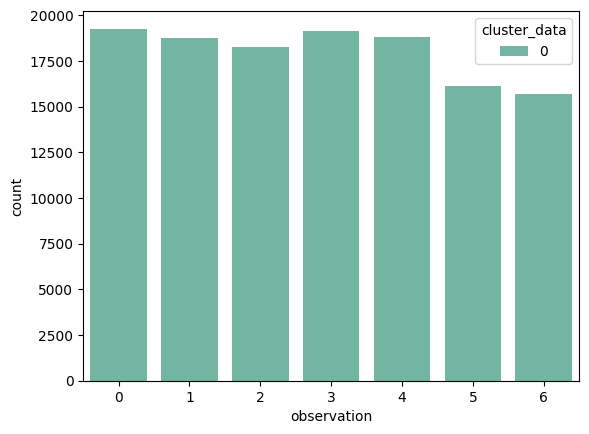

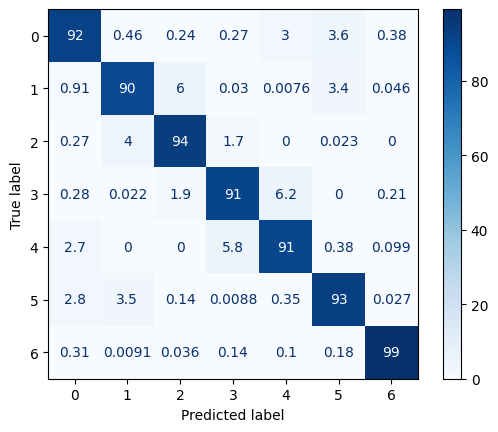

{'average_accuracy': 0.9175519264309497, 'average_f1_macro': np.float64(0.9190948592136919), 'average_f1_micro': np.float64(0.9175519264309497), 'average_auc': np.float64(0.995132960611377), 'average_acc_kelas_generatif': 0.9029787210024066, 'average_acc_fase_padi': 0.9038222222222222}
{'val_accuracy': 0.927417071541014, 'val_f1_macro': np.float64(0.9288082767685725), 'val_f1_micro': np.float64(0.927417071541014), 'val_auc': np.float64(0.9962633668913182), 'val_acc_kelas_generatif': 0.9136244867487868, 'val_acc_fase_padi': 0.9146873392887754, 'val_relative_acc': np.float64(99.95547852633922)}
CLUSTER:  1


[I 2024-10-23 11:09:56,830] A new study created in memory with name: no-name-7cf7175e-47d9-475c-98a4-19c9bf67a29d


[6 2 3 1 5 0 4]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 11:10:56,796] Trial 0 finished with value: 0.8805061533205535 and parameters: {'max_depth': 8, 'learning_rate': 0.03128942514825682, 'reg_lambda': 2.2028658277488815, 'min_child_weight': 76}. Best is trial 0 with value: 0.8805061533205535.


[I 2024-10-23 11:11:19,148] Trial 1 finished with value: 0.8826465699347531 and parameters: {'max_depth': 10, 'learning_rate': 0.09715851500934965, 'reg_lambda': 3.278806372609209, 'min_child_weight': 96}. Best is trial 1 with value: 0.8826465699347531.


[I 2024-10-23 11:12:39,374] Trial 2 finished with value: 0.8750517286169526 and parameters: {'max_depth': 8, 'learning_rate': 0.0118947384344835, 'reg_lambda': 0.21358193291916028, 'min_child_weight': 73}. Best is trial 1 with value: 0.8826465699347531.


[I 2024-10-23 11:13:41,663] Trial 3 finished with value: 0.8805229023700827 and parameters: {'max_depth': 7, 'learning_rate': 0.034699331522423923, 'reg_lambda': 4.309876824299642, 'min_child_weight': 76}. Best is trial 1 with value: 0.8826465699347531.


[I 2024-10-23 11:14:38,779] Trial 4 finished with value: 0.8820511298883907 and parameters: {'max_depth': 10, 'learning_rate': 0.0369433206319941, 'reg_lambda': 0.11606211293660981, 'min_child_weight': 96}. Best is trial 1 with value: 0.8826465699347531.


[I 2024-10-23 11:15:06,596] Trial 5 finished with value: 0.8814243815949245 and parameters: {'max_depth': 7, 'learning_rate': 0.0751005424697689, 'reg_lambda': 1.9619468441415517, 'min_child_weight': 54}. Best is trial 1 with value: 0.8826465699347531.


[I 2024-10-23 11:16:02,217] Trial 6 finished with value: 0.8827995735879037 and parameters: {'max_depth': 10, 'learning_rate': 0.037056452000373025, 'reg_lambda': 3.7231422775358194, 'min_child_weight': 96}. Best is trial 6 with value: 0.8827995735879037.


[I 2024-10-23 11:16:34,255] Trial 7 finished with value: 0.881733518917998 and parameters: {'max_depth': 8, 'learning_rate': 0.06849848800137484, 'reg_lambda': 1.010155978980255, 'min_child_weight': 81}. Best is trial 6 with value: 0.8827995735879037.


[I 2024-10-23 11:17:15,219] Trial 8 finished with value: 0.8838791472060006 and parameters: {'max_depth': 9, 'learning_rate': 0.048091519483633945, 'reg_lambda': 4.490353834172416, 'min_child_weight': 61}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:17:41,216] Trial 9 finished with value: 0.8804166688186806 and parameters: {'max_depth': 6, 'learning_rate': 0.08795074721482363, 'reg_lambda': 2.7309705470846835, 'min_child_weight': 68}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:18:15,781] Trial 10 finished with value: 0.8827867647286358 and parameters: {'max_depth': 9, 'learning_rate': 0.0559829519042688, 'reg_lambda': 4.873645464121943, 'min_child_weight': 52}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:18:55,076] Trial 11 finished with value: 0.8825829726192227 and parameters: {'max_depth': 9, 'learning_rate': 0.05119175500934304, 'reg_lambda': 3.6895833562877867, 'min_child_weight': 62}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:20:16,294] Trial 12 finished with value: 0.880025084371634 and parameters: {'max_depth': 9, 'learning_rate': 0.017874469422487375, 'reg_lambda': 4.010105671638891, 'min_child_weight': 86}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:20:58,642] Trial 13 finished with value: 0.8831009993317293 and parameters: {'max_depth': 10, 'learning_rate': 0.04867246123472894, 'reg_lambda': 4.83446402029181, 'min_child_weight': 88}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:21:39,252] Trial 14 finished with value: 0.8828396160661051 and parameters: {'max_depth': 9, 'learning_rate': 0.05245637248860864, 'reg_lambda': 4.911212353637635, 'min_child_weight': 87}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:22:10,332] Trial 15 finished with value: 0.8837271204755736 and parameters: {'max_depth': 10, 'learning_rate': 0.06495054970412197, 'reg_lambda': 4.3812489427037535, 'min_child_weight': 62}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:22:41,089] Trial 16 finished with value: 0.8827789572423396 and parameters: {'max_depth': 9, 'learning_rate': 0.06446287827611592, 'reg_lambda': 3.001663411739958, 'min_child_weight': 61}. Best is trial 8 with value: 0.8838791472060006.


[I 2024-10-23 11:23:09,949] Trial 17 finished with value: 0.8841154097834968 and parameters: {'max_depth': 10, 'learning_rate': 0.07257521763904894, 'reg_lambda': 4.216785968386431, 'min_child_weight': 60}. Best is trial 17 with value: 0.8841154097834968.


[I 2024-10-23 11:23:35,007] Trial 18 finished with value: 0.8827478625825069 and parameters: {'max_depth': 9, 'learning_rate': 0.0815346728863932, 'reg_lambda': 3.3571707487936826, 'min_child_weight': 56}. Best is trial 17 with value: 0.8841154097834968.


[I 2024-10-23 11:23:57,106] Trial 19 finished with value: 0.8811853726346007 and parameters: {'max_depth': 7, 'learning_rate': 0.09987186798286828, 'reg_lambda': 1.3857231168186113, 'min_child_weight': 66}. Best is trial 17 with value: 0.8841154097834968.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.07257521763904894, 'reg_lambda': 4.216785968386431, 'min_child_weight': 60}
Best Score: 0.8841154097834968
Start the modelling
[0]	train-mlogloss:1.78013	eval-mlogloss:1.78709


[100]	train-mlogloss:0.10844	eval-mlogloss:0.31308


[200]	train-mlogloss:0.04598	eval-mlogloss:0.28624


[300]	train-mlogloss:0.02767	eval-mlogloss:0.28443


[400]	train-mlogloss:0.01970	eval-mlogloss:0.28755


[500]	train-mlogloss:0.01530	eval-mlogloss:0.29170


[600]	train-mlogloss:0.01265	eval-mlogloss:0.29521


[700]	train-mlogloss:0.01084	eval-mlogloss:0.29899


[800]	train-mlogloss:0.00958	eval-mlogloss:0.30216


[900]	train-mlogloss:0.00864	eval-mlogloss:0.30520


[1000]	train-mlogloss:0.00792	eval-mlogloss:0.30766


[1100]	train-mlogloss:0.00736	eval-mlogloss:0.31014


[1200]	train-mlogloss:0.00690	eval-mlogloss:0.31220


[1280]	train-mlogloss:0.00658	eval-mlogloss:0.31382


[0]	train-mlogloss:1.77925	eval-mlogloss:1.78790


[100]	train-mlogloss:0.11197	eval-mlogloss:0.31481


[200]	train-mlogloss:0.04769	eval-mlogloss:0.28382


[300]	train-mlogloss:0.02798	eval-mlogloss:0.28084


[400]	train-mlogloss:0.01979	eval-mlogloss:0.28280


[500]	train-mlogloss:0.01542	eval-mlogloss:0.28578


[600]	train-mlogloss:0.01269	eval-mlogloss:0.28868


[700]	train-mlogloss:0.01090	eval-mlogloss:0.29211


[800]	train-mlogloss:0.00965	eval-mlogloss:0.29500


[900]	train-mlogloss:0.00871	eval-mlogloss:0.29755


[1000]	train-mlogloss:0.00798	eval-mlogloss:0.29996


[1100]	train-mlogloss:0.00741	eval-mlogloss:0.30216


[1200]	train-mlogloss:0.00694	eval-mlogloss:0.30419


[1286]	train-mlogloss:0.00660	eval-mlogloss:0.30586


[0]	train-mlogloss:1.77922	eval-mlogloss:1.78766


[100]	train-mlogloss:0.10727	eval-mlogloss:0.31204


[200]	train-mlogloss:0.04536	eval-mlogloss:0.28554


[300]	train-mlogloss:0.02696	eval-mlogloss:0.28463


[400]	train-mlogloss:0.01919	eval-mlogloss:0.28728


[500]	train-mlogloss:0.01499	eval-mlogloss:0.29197


[600]	train-mlogloss:0.01239	eval-mlogloss:0.29573


[700]	train-mlogloss:0.01065	eval-mlogloss:0.29911


[800]	train-mlogloss:0.00945	eval-mlogloss:0.30210


[900]	train-mlogloss:0.00855	eval-mlogloss:0.30494


[1000]	train-mlogloss:0.00784	eval-mlogloss:0.30762


[1100]	train-mlogloss:0.00727	eval-mlogloss:0.31014


[1200]	train-mlogloss:0.00682	eval-mlogloss:0.31246


[1264]	train-mlogloss:0.00657	eval-mlogloss:0.31387


[0]	train-mlogloss:1.77704	eval-mlogloss:1.78446


[50]	train-mlogloss:0.23960	eval-mlogloss:0.38483


[100]	train-mlogloss:0.11442	eval-mlogloss:0.29573


[150]	train-mlogloss:0.07490	eval-mlogloss:0.27342


[200]	train-mlogloss:0.05256	eval-mlogloss:0.26358


[250]	train-mlogloss:0.03883	eval-mlogloss:0.25961


[300]	train-mlogloss:0.03034	eval-mlogloss:0.25824


[350]	train-mlogloss:0.02474	eval-mlogloss:0.25850


[351]	train-mlogloss:0.02462	eval-mlogloss:0.25848



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11992
           1       0.92      0.93      0.92     11487
           2       0.94      0.95      0.95     10924
           3       0.95      0.96      0.95     12205
           4       0.92      0.95      0.94     10248
           5       0.78      0.62      0.69      5521
           6       0.88      0.90      0.89     13037

    accuracy                           0.91     75414
   macro avg       0.90      0.89      0.89     75414
weighted avg       0.91      0.91      0.91     75414



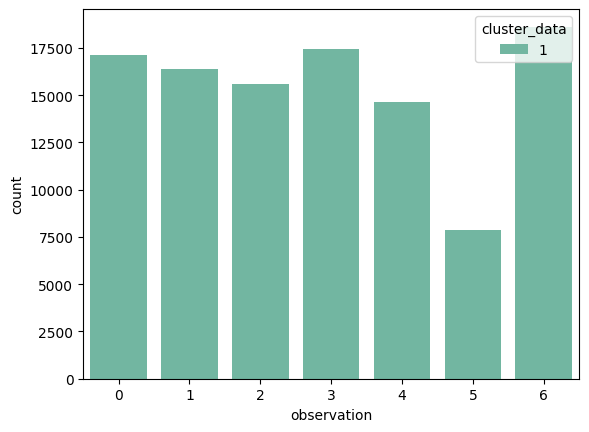

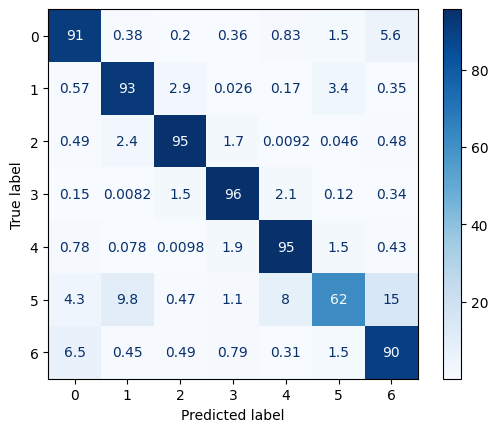

{'average_accuracy': 0.9025371256543985, 'average_f1_macro': np.float64(0.884333942682647), 'average_f1_micro': np.float64(0.9025371256543985), 'average_auc': np.float64(0.9876449549715942), 'average_acc_kelas_generatif': 0.9543016978354659, 'average_acc_fase_padi': 0.940500338066261}
{'val_accuracy': 0.9085183122497149, 'val_f1_macro': np.float64(0.8914168587797455), 'val_f1_micro': np.float64(0.9085183122497149), 'val_auc': np.float64(0.9897813535075574), 'val_acc_kelas_generatif': 0.957230643179025, 'val_acc_fase_padi': 0.9460814907275321, 'val_relative_acc': np.float64(99.7160019614253)}
CLUSTER:  2


[I 2024-10-23 11:25:37,438] A new study created in memory with name: no-name-c381abd5-c031-4672-a498-185c517c64b1


[2 1 0 4 6 3 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 11:26:06,050] Trial 0 finished with value: 0.6877055184460134 and parameters: {'max_depth': 9, 'learning_rate': 0.05050254107262216, 'reg_lambda': 1.618029223845682, 'min_child_weight': 61}. Best is trial 0 with value: 0.6877055184460134.


[I 2024-10-23 11:26:23,768] Trial 1 finished with value: 0.6890812919115884 and parameters: {'max_depth': 8, 'learning_rate': 0.09501196683518374, 'reg_lambda': 0.5187192189233394, 'min_child_weight': 87}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:27:36,848] Trial 2 finished with value: 0.6855704243385424 and parameters: {'max_depth': 9, 'learning_rate': 0.01738548084295765, 'reg_lambda': 4.075309242257729, 'min_child_weight': 61}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:27:57,411] Trial 3 finished with value: 0.683641988814163 and parameters: {'max_depth': 6, 'learning_rate': 0.08598406471893218, 'reg_lambda': 2.7078992254055407, 'min_child_weight': 86}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:28:33,047] Trial 4 finished with value: 0.684264086535428 and parameters: {'max_depth': 6, 'learning_rate': 0.0464870775194512, 'reg_lambda': 1.5601700271015078, 'min_child_weight': 85}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:28:59,027] Trial 5 finished with value: 0.6886730106043175 and parameters: {'max_depth': 7, 'learning_rate': 0.05876314010033369, 'reg_lambda': 0.4745114696428486, 'min_child_weight': 59}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:29:20,603] Trial 6 finished with value: 0.6876088310019105 and parameters: {'max_depth': 8, 'learning_rate': 0.07507437506449473, 'reg_lambda': 0.21888802236487276, 'min_child_weight': 57}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:29:40,261] Trial 7 finished with value: 0.6884358612554581 and parameters: {'max_depth': 8, 'learning_rate': 0.08298375104314737, 'reg_lambda': 3.0528547866969746, 'min_child_weight': 63}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:30:29,267] Trial 8 finished with value: 0.6789197722452794 and parameters: {'max_depth': 6, 'learning_rate': 0.018368790118744028, 'reg_lambda': 0.9342365080671085, 'min_child_weight': 78}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:31:04,950] Trial 9 finished with value: 0.6863052776558677 and parameters: {'max_depth': 6, 'learning_rate': 0.049743937134555535, 'reg_lambda': 3.3473130963303364, 'min_child_weight': 94}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:31:23,911] Trial 10 finished with value: 0.6868807714877647 and parameters: {'max_depth': 10, 'learning_rate': 0.09845072595404497, 'reg_lambda': 4.750723154691984, 'min_child_weight': 99}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:31:48,015] Trial 11 finished with value: 0.6868023753223466 and parameters: {'max_depth': 7, 'learning_rate': 0.0661934692342663, 'reg_lambda': 0.12040550837095243, 'min_child_weight': 50}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:32:38,909] Trial 12 finished with value: 0.6888184460098197 and parameters: {'max_depth': 8, 'learning_rate': 0.030101829639944087, 'reg_lambda': 1.4566763955065751, 'min_child_weight': 72}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:33:21,877] Trial 13 finished with value: 0.6880036377071245 and parameters: {'max_depth': 9, 'learning_rate': 0.03600377918880019, 'reg_lambda': 1.797131709150917, 'min_child_weight': 73}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:34:13,161] Trial 14 finished with value: 0.685702312652421 and parameters: {'max_depth': 7, 'learning_rate': 0.03077285227233834, 'reg_lambda': 1.0687132030732065, 'min_child_weight': 74}. Best is trial 1 with value: 0.6890812919115884.


[I 2024-10-23 11:34:31,670] Trial 15 finished with value: 0.6893016992979222 and parameters: {'max_depth': 8, 'learning_rate': 0.09939776477599126, 'reg_lambda': 2.220308414019091, 'min_child_weight': 83}. Best is trial 15 with value: 0.6893016992979222.


[I 2024-10-23 11:34:50,732] Trial 16 finished with value: 0.6883801691198338 and parameters: {'max_depth': 8, 'learning_rate': 0.09694327204624792, 'reg_lambda': 2.225459685539334, 'min_child_weight': 86}. Best is trial 15 with value: 0.6893016992979222.


[I 2024-10-23 11:35:10,663] Trial 17 finished with value: 0.6878145047821563 and parameters: {'max_depth': 10, 'learning_rate': 0.08907024841691498, 'reg_lambda': 3.811719031421851, 'min_child_weight': 82}. Best is trial 15 with value: 0.6893016992979222.


[I 2024-10-23 11:35:34,449] Trial 18 finished with value: 0.6895021664823316 and parameters: {'max_depth': 9, 'learning_rate': 0.07411742461292413, 'reg_lambda': 2.3400249591438897, 'min_child_weight': 93}. Best is trial 18 with value: 0.6895021664823316.


[I 2024-10-23 11:35:59,460] Trial 19 finished with value: 0.6892694455094369 and parameters: {'max_depth': 9, 'learning_rate': 0.07174427963037236, 'reg_lambda': 2.5372315031961445, 'min_child_weight': 94}. Best is trial 18 with value: 0.6895021664823316.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.07411742461292413, 'reg_lambda': 2.3400249591438897, 'min_child_weight': 93}
Best Score: 0.6895021664823316
Start the modelling
[0]	train-mlogloss:1.83687	eval-mlogloss:1.85406


[100]	train-mlogloss:0.41798	eval-mlogloss:0.84802


[200]	train-mlogloss:0.27782	eval-mlogloss:0.82195


[300]	train-mlogloss:0.19669	eval-mlogloss:0.81404


[400]	train-mlogloss:0.14628	eval-mlogloss:0.81568


[500]	train-mlogloss:0.11428	eval-mlogloss:0.82112


[600]	train-mlogloss:0.09064	eval-mlogloss:0.82818


[700]	train-mlogloss:0.07599	eval-mlogloss:0.83705


[800]	train-mlogloss:0.06512	eval-mlogloss:0.84494


[900]	train-mlogloss:0.05692	eval-mlogloss:0.85223


[1000]	train-mlogloss:0.05026	eval-mlogloss:0.85932


[1100]	train-mlogloss:0.04479	eval-mlogloss:0.86627


[1200]	train-mlogloss:0.04050	eval-mlogloss:0.87326


[1300]	train-mlogloss:0.03704	eval-mlogloss:0.87977


[1337]	train-mlogloss:0.03583	eval-mlogloss:0.88208


[0]	train-mlogloss:1.83578	eval-mlogloss:1.85458


[100]	train-mlogloss:0.42305	eval-mlogloss:0.87082


[200]	train-mlogloss:0.26974	eval-mlogloss:0.83818


[300]	train-mlogloss:0.19082	eval-mlogloss:0.83451


[400]	train-mlogloss:0.14230	eval-mlogloss:0.83794


[500]	train-mlogloss:0.11269	eval-mlogloss:0.84711


[600]	train-mlogloss:0.09265	eval-mlogloss:0.85674


[700]	train-mlogloss:0.07769	eval-mlogloss:0.86653


[800]	train-mlogloss:0.06568	eval-mlogloss:0.87614


[900]	train-mlogloss:0.05734	eval-mlogloss:0.88554


[1000]	train-mlogloss:0.05003	eval-mlogloss:0.89613


[1100]	train-mlogloss:0.04466	eval-mlogloss:0.90563


[1200]	train-mlogloss:0.04049	eval-mlogloss:0.91398


[1294]	train-mlogloss:0.03700	eval-mlogloss:0.92122


[0]	train-mlogloss:1.83627	eval-mlogloss:1.85530


[100]	train-mlogloss:0.40642	eval-mlogloss:0.85678


[200]	train-mlogloss:0.26425	eval-mlogloss:0.82746


[300]	train-mlogloss:0.18735	eval-mlogloss:0.82317


[400]	train-mlogloss:0.13679	eval-mlogloss:0.82512


[500]	train-mlogloss:0.10633	eval-mlogloss:0.83209


[600]	train-mlogloss:0.08568	eval-mlogloss:0.84098


[700]	train-mlogloss:0.07235	eval-mlogloss:0.84958


[800]	train-mlogloss:0.06200	eval-mlogloss:0.85916


[900]	train-mlogloss:0.05422	eval-mlogloss:0.86809


[1000]	train-mlogloss:0.04813	eval-mlogloss:0.87750


[1100]	train-mlogloss:0.04307	eval-mlogloss:0.88544


[1200]	train-mlogloss:0.03877	eval-mlogloss:0.89304


[1272]	train-mlogloss:0.03626	eval-mlogloss:0.89922


[0]	train-mlogloss:1.83461	eval-mlogloss:1.85160


[50]	train-mlogloss:0.61305	eval-mlogloss:0.90826


[100]	train-mlogloss:0.44086	eval-mlogloss:0.82787


[150]	train-mlogloss:0.35779	eval-mlogloss:0.80319


[200]	train-mlogloss:0.29963	eval-mlogloss:0.79200


[250]	train-mlogloss:0.25288	eval-mlogloss:0.78437


[300]	train-mlogloss:0.21634	eval-mlogloss:0.78006


[350]	train-mlogloss:0.18673	eval-mlogloss:0.77812


[400]	train-mlogloss:0.16318	eval-mlogloss:0.77757


[445]	train-mlogloss:0.14549	eval-mlogloss:0.77753



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     12859
           1       0.77      0.76      0.76      4498
           2       0.71      0.64      0.67      5863
           3       0.87      0.92      0.89      7563
           4       0.85      0.90      0.87      4945
           5       0.57      0.50      0.53      5873
           6       0.46      0.50      0.48      6032

    accuracy                           0.71     47633
   macro avg       0.71      0.71      0.70     47633
weighted avg       0.71      0.71      0.71     47633



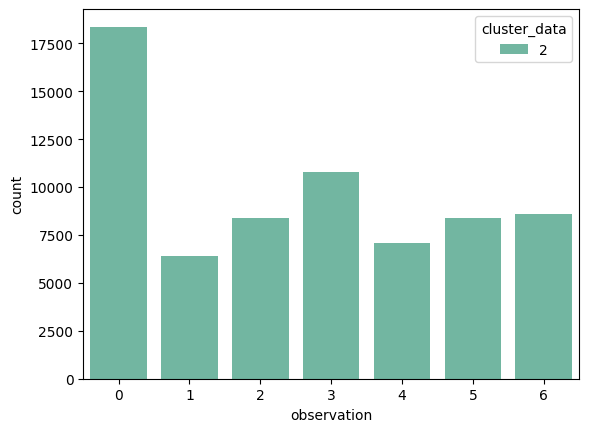

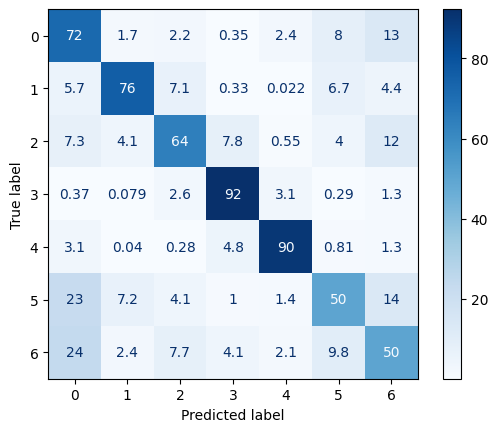

{'average_accuracy': 0.7000927837322646, 'average_f1_macro': np.float64(0.6899358200606747), 'average_f1_micro': np.float64(0.7000927837322646), 'average_auc': np.float64(0.9264288867861534), 'average_acc_kelas_generatif': 0.921629778097555, 'average_acc_fase_padi': 0.797368758301197}
{'val_accuracy': 0.7094871202737598, 'val_f1_macro': np.float64(0.7048212420415542), 'val_f1_micro': np.float64(0.7094871202737598), 'val_auc': np.float64(0.9350884887448203), 'val_acc_kelas_generatif': 0.9233108554806294, 'val_acc_fase_padi': 0.8125847216756308, 'val_relative_acc': np.float64(97.44358465340518)}
CLUSTER:  3


[I 2024-10-23 11:37:29,540] A new study created in memory with name: no-name-49253c00-8388-4050-b803-b467bb5cebd3


[1 2 3 4 0 5 6]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 11:38:23,700] Trial 0 finished with value: 0.9260388521303019 and parameters: {'max_depth': 6, 'learning_rate': 0.02635941546185417, 'reg_lambda': 1.5938843265912221, 'min_child_weight': 52}. Best is trial 0 with value: 0.9260388521303019.


[I 2024-10-23 11:39:00,853] Trial 1 finished with value: 0.9262724369941736 and parameters: {'max_depth': 10, 'learning_rate': 0.04042872157143568, 'reg_lambda': 0.6849612463486459, 'min_child_weight': 95}. Best is trial 1 with value: 0.9262724369941736.


[I 2024-10-23 11:39:51,980] Trial 2 finished with value: 0.9258549116381419 and parameters: {'max_depth': 10, 'learning_rate': 0.029427847554497982, 'reg_lambda': 2.5703364461491476, 'min_child_weight': 89}. Best is trial 1 with value: 0.9262724369941736.


[I 2024-10-23 11:40:45,066] Trial 3 finished with value: 0.9253285426791594 and parameters: {'max_depth': 6, 'learning_rate': 0.02778055781468214, 'reg_lambda': 1.373990463199246, 'min_child_weight': 58}. Best is trial 1 with value: 0.9262724369941736.


[I 2024-10-23 11:41:55,555] Trial 4 finished with value: 0.9254332814571168 and parameters: {'max_depth': 8, 'learning_rate': 0.017088753846668452, 'reg_lambda': 4.298199589070735, 'min_child_weight': 66}. Best is trial 1 with value: 0.9262724369941736.


[I 2024-10-23 11:42:15,764] Trial 5 finished with value: 0.9269673417027073 and parameters: {'max_depth': 10, 'learning_rate': 0.0799464909324228, 'reg_lambda': 2.424381888084999, 'min_child_weight': 75}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:43:26,457] Trial 6 finished with value: 0.926540973618089 and parameters: {'max_depth': 8, 'learning_rate': 0.018822764249217125, 'reg_lambda': 3.1188206745726137, 'min_child_weight': 53}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:44:27,783] Trial 7 finished with value: 0.9262286228687908 and parameters: {'max_depth': 10, 'learning_rate': 0.023798965874642614, 'reg_lambda': 0.45311040153967663, 'min_child_weight': 94}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:45:01,183] Trial 8 finished with value: 0.9259660200019181 and parameters: {'max_depth': 9, 'learning_rate': 0.045169877353609854, 'reg_lambda': 3.603738575860377, 'min_child_weight': 77}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:45:44,577] Trial 9 finished with value: 0.926390236813741 and parameters: {'max_depth': 9, 'learning_rate': 0.034727969443809924, 'reg_lambda': 4.18916137725941, 'min_child_weight': 79}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:46:05,637] Trial 10 finished with value: 0.9258959168894249 and parameters: {'max_depth': 7, 'learning_rate': 0.08373709258849393, 'reg_lambda': 2.1935708190481984, 'min_child_weight': 65}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:46:28,237] Trial 11 finished with value: 0.9267587475665064 and parameters: {'max_depth': 8, 'learning_rate': 0.07192455303732881, 'reg_lambda': 3.044418263343852, 'min_child_weight': 68}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:46:50,066] Trial 12 finished with value: 0.9262748841714242 and parameters: {'max_depth': 8, 'learning_rate': 0.07477098031008995, 'reg_lambda': 2.9832813623994734, 'min_child_weight': 71}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:47:13,404] Trial 13 finished with value: 0.9263804732326842 and parameters: {'max_depth': 9, 'learning_rate': 0.06752947256021087, 'reg_lambda': 4.86024151586513, 'min_child_weight': 84}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:47:32,644] Trial 14 finished with value: 0.926232735332453 and parameters: {'max_depth': 7, 'learning_rate': 0.09660906337972142, 'reg_lambda': 2.0491432951676467, 'min_child_weight': 70}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:48:00,559] Trial 15 finished with value: 0.9256878376638008 and parameters: {'max_depth': 7, 'learning_rate': 0.05713950922058106, 'reg_lambda': 3.5099405318816066, 'min_child_weight': 82}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:48:17,674] Trial 16 finished with value: 0.9266515459062307 and parameters: {'max_depth': 9, 'learning_rate': 0.09464285157379608, 'reg_lambda': 1.260493443302576, 'min_child_weight': 61}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:48:44,993] Trial 17 finished with value: 0.9259647309755569 and parameters: {'max_depth': 7, 'learning_rate': 0.061300039920400604, 'reg_lambda': 2.713360264267877, 'min_child_weight': 75}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:49:04,804] Trial 18 finished with value: 0.9268198464717815 and parameters: {'max_depth': 9, 'learning_rate': 0.08186647211591253, 'reg_lambda': 2.036522556250652, 'min_child_weight': 72}. Best is trial 5 with value: 0.9269673417027073.


[I 2024-10-23 11:49:25,181] Trial 19 finished with value: 0.9259670409370916 and parameters: {'max_depth': 10, 'learning_rate': 0.0844499700101853, 'reg_lambda': 1.8860776581603458, 'min_child_weight': 86}. Best is trial 5 with value: 0.9269673417027073.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.0799464909324228, 'reg_lambda': 2.424381888084999, 'min_child_weight': 75}
Best Score: 0.9269673417027073
Start the modelling
[0]	train-mlogloss:1.72926	eval-mlogloss:1.73774


[100]	train-mlogloss:0.06849	eval-mlogloss:0.19687


[200]	train-mlogloss:0.03123	eval-mlogloss:0.18593


[300]	train-mlogloss:0.01961	eval-mlogloss:0.18765


[400]	train-mlogloss:0.01432	eval-mlogloss:0.19127


[500]	train-mlogloss:0.01148	eval-mlogloss:0.19462


[600]	train-mlogloss:0.00973	eval-mlogloss:0.19746


[700]	train-mlogloss:0.00854	eval-mlogloss:0.19999


[800]	train-mlogloss:0.00769	eval-mlogloss:0.20215


[900]	train-mlogloss:0.00705	eval-mlogloss:0.20416


[1000]	train-mlogloss:0.00654	eval-mlogloss:0.20572


[1100]	train-mlogloss:0.00612	eval-mlogloss:0.20724


[1200]	train-mlogloss:0.00577	eval-mlogloss:0.20860


[1215]	train-mlogloss:0.00573	eval-mlogloss:0.20870


[0]	train-mlogloss:1.73058	eval-mlogloss:1.73838


[100]	train-mlogloss:0.07012	eval-mlogloss:0.19913


[200]	train-mlogloss:0.03224	eval-mlogloss:0.18784


[300]	train-mlogloss:0.01982	eval-mlogloss:0.18954


[400]	train-mlogloss:0.01442	eval-mlogloss:0.19271


[500]	train-mlogloss:0.01152	eval-mlogloss:0.19615


[600]	train-mlogloss:0.00974	eval-mlogloss:0.19928


[700]	train-mlogloss:0.00854	eval-mlogloss:0.20201


[800]	train-mlogloss:0.00768	eval-mlogloss:0.20433


[900]	train-mlogloss:0.00702	eval-mlogloss:0.20637


[1000]	train-mlogloss:0.00650	eval-mlogloss:0.20831


[1100]	train-mlogloss:0.00610	eval-mlogloss:0.20993


[1200]	train-mlogloss:0.00575	eval-mlogloss:0.21143


[0]	train-mlogloss:1.72863	eval-mlogloss:1.73685


[100]	train-mlogloss:0.06901	eval-mlogloss:0.20141


[200]	train-mlogloss:0.03188	eval-mlogloss:0.19072


[300]	train-mlogloss:0.01946	eval-mlogloss:0.19265


[400]	train-mlogloss:0.01417	eval-mlogloss:0.19613


[500]	train-mlogloss:0.01133	eval-mlogloss:0.19947


[600]	train-mlogloss:0.00959	eval-mlogloss:0.20281


[700]	train-mlogloss:0.00842	eval-mlogloss:0.20535


[800]	train-mlogloss:0.00758	eval-mlogloss:0.20779


[900]	train-mlogloss:0.00694	eval-mlogloss:0.20978


[1000]	train-mlogloss:0.00643	eval-mlogloss:0.21161


[1100]	train-mlogloss:0.00603	eval-mlogloss:0.21296


[1200]	train-mlogloss:0.00569	eval-mlogloss:0.21448


[1206]	train-mlogloss:0.00567	eval-mlogloss:0.21454


[0]	train-mlogloss:1.72693	eval-mlogloss:1.73391


[50]	train-mlogloss:0.14487	eval-mlogloss:0.24098


[100]	train-mlogloss:0.07424	eval-mlogloss:0.18861


[150]	train-mlogloss:0.05082	eval-mlogloss:0.17890


[200]	train-mlogloss:0.03603	eval-mlogloss:0.17559


[250]	train-mlogloss:0.02717	eval-mlogloss:0.17515


[284]	train-mlogloss:0.02305	eval-mlogloss:0.17562



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     12534
           1       0.92      0.90      0.91     12952
           2       0.91      0.93      0.92     12625
           3       0.95      0.94      0.95     13029
           4       0.93      0.93      0.93     12758
           5       0.91      0.91      0.91     12181
           6       0.99      0.99      0.99     12086

    accuracy                           0.93     88165
   macro avg       0.93      0.93      0.93     88165
weighted avg       0.93      0.93      0.93     88165



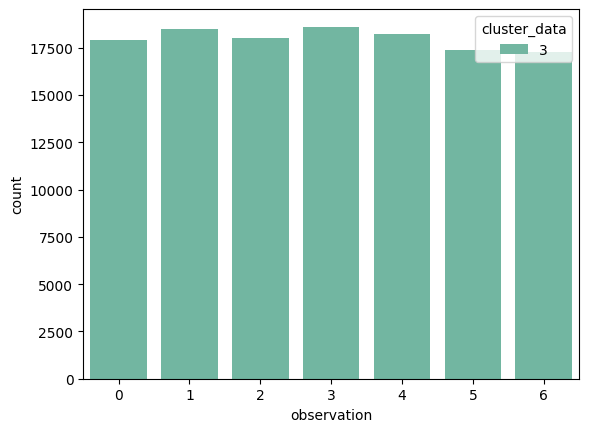

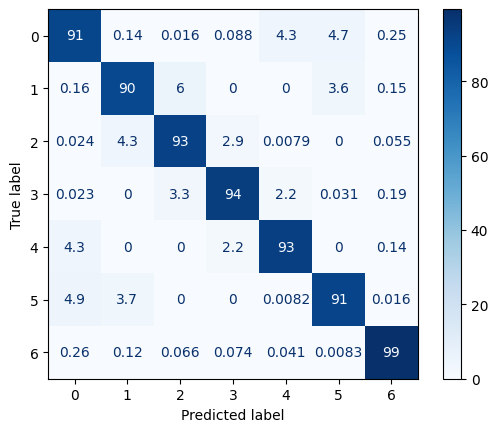

{'average_accuracy': 0.9281990207754399, 'average_f1_macro': np.float64(0.9284366915520413), 'average_f1_micro': np.float64(0.9281990207754399), 'average_auc': np.float64(0.9961943840133819), 'average_acc_kelas_generatif': 0.941260035788404, 'average_acc_fase_padi': 0.9241319694387425}
{'val_accuracy': 0.9306981228378608, 'val_f1_macro': np.float64(0.9309611005882757), 'val_f1_micro': np.float64(0.9306981228378608), 'val_auc': np.float64(0.9966730364379054), 'val_acc_kelas_generatif': 0.9422826003530586, 'val_acc_fase_padi': 0.9260376917685539, 'val_relative_acc': np.float64(99.99197431781701)}
CLUSTER:  4


[I 2024-10-23 11:50:50,529] A new study created in memory with name: no-name-7eeded51-8fbb-4cce-931d-c319319e3764


[1 6 3 2 4 5 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 11:51:21,403] Trial 0 finished with value: 0.9583280888312656 and parameters: {'max_depth': 7, 'learning_rate': 0.06354212428289283, 'reg_lambda': 3.028262933868155, 'min_child_weight': 59}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:52:02,748] Trial 1 finished with value: 0.957282410631485 and parameters: {'max_depth': 10, 'learning_rate': 0.045992270046187944, 'reg_lambda': 2.617901706005055, 'min_child_weight': 72}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:52:58,549] Trial 2 finished with value: 0.9545123838371281 and parameters: {'max_depth': 7, 'learning_rate': 0.02408258640125974, 'reg_lambda': 1.1594095491478307, 'min_child_weight': 96}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:53:48,678] Trial 3 finished with value: 0.9560910946727365 and parameters: {'max_depth': 6, 'learning_rate': 0.04012864590852677, 'reg_lambda': 3.0666072680103467, 'min_child_weight': 92}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:54:41,069] Trial 4 finished with value: 0.952965959561479 and parameters: {'max_depth': 6, 'learning_rate': 0.019843842639320687, 'reg_lambda': 0.20702403458810875, 'min_child_weight': 97}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:55:21,103] Trial 5 finished with value: 0.9565670336788302 and parameters: {'max_depth': 10, 'learning_rate': 0.05535595848557516, 'reg_lambda': 4.654711059360209, 'min_child_weight': 100}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:55:57,287] Trial 6 finished with value: 0.9564672243707939 and parameters: {'max_depth': 6, 'learning_rate': 0.06476424670385265, 'reg_lambda': 3.9333334255047396, 'min_child_weight': 88}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:56:23,942] Trial 7 finished with value: 0.9575239484733208 and parameters: {'max_depth': 8, 'learning_rate': 0.07871430009241455, 'reg_lambda': 2.5420558020652204, 'min_child_weight': 84}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:56:59,082] Trial 8 finished with value: 0.958148420090127 and parameters: {'max_depth': 7, 'learning_rate': 0.054815524278115924, 'reg_lambda': 0.5631115708648087, 'min_child_weight': 51}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:58:00,074] Trial 9 finished with value: 0.9556235197374662 and parameters: {'max_depth': 7, 'learning_rate': 0.018644539991473252, 'reg_lambda': 1.282447958522048, 'min_child_weight': 56}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:58:21,328] Trial 10 finished with value: 0.9574508189120591 and parameters: {'max_depth': 9, 'learning_rate': 0.09810499972160126, 'reg_lambda': 3.377544584334563, 'min_child_weight': 64}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:58:50,158] Trial 11 finished with value: 0.9573530997518437 and parameters: {'max_depth': 8, 'learning_rate': 0.07152776190762701, 'reg_lambda': 1.7246815807613032, 'min_child_weight': 50}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:59:15,052] Trial 12 finished with value: 0.957969880660305 and parameters: {'max_depth': 7, 'learning_rate': 0.08687206791598372, 'reg_lambda': 0.5917631914972072, 'min_child_weight': 62}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 11:59:48,950] Trial 13 finished with value: 0.9575097346495469 and parameters: {'max_depth': 7, 'learning_rate': 0.05494661840711612, 'reg_lambda': 1.6957315163725186, 'min_child_weight': 51}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 12:00:40,822] Trial 14 finished with value: 0.9565201105305711 and parameters: {'max_depth': 8, 'learning_rate': 0.03582165275138087, 'reg_lambda': 2.355392680625501, 'min_child_weight': 72}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 12:01:11,320] Trial 15 finished with value: 0.9569891433930645 and parameters: {'max_depth': 8, 'learning_rate': 0.06218169993979454, 'reg_lambda': 3.96614649313151, 'min_child_weight': 61}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 12:01:39,288] Trial 16 finished with value: 0.9568702644486354 and parameters: {'max_depth': 9, 'learning_rate': 0.08088685344613346, 'reg_lambda': 3.525870790331842, 'min_child_weight': 79}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 12:02:24,922] Trial 17 finished with value: 0.9579650129624215 and parameters: {'max_depth': 7, 'learning_rate': 0.0488521902002567, 'reg_lambda': 4.845000742927973, 'min_child_weight': 66}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 12:03:17,808] Trial 18 finished with value: 0.9568076056830196 and parameters: {'max_depth': 6, 'learning_rate': 0.0335299068283386, 'reg_lambda': 2.033345877364523, 'min_child_weight': 56}. Best is trial 0 with value: 0.9583280888312656.


[I 2024-10-23 12:03:46,155] Trial 19 finished with value: 0.9573521786538599 and parameters: {'max_depth': 9, 'learning_rate': 0.06839531249678486, 'reg_lambda': 0.8328647996492273, 'min_child_weight': 56}. Best is trial 0 with value: 0.9583280888312656.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.06354212428289283, 'reg_lambda': 3.028262933868155, 'min_child_weight': 59}
Best Score: 0.9583280888312656
Start the modelling
[0]	train-mlogloss:1.77270	eval-mlogloss:1.77776


[100]	train-mlogloss:0.08079	eval-mlogloss:0.15905


[200]	train-mlogloss:0.03284	eval-mlogloss:0.12429


[300]	train-mlogloss:0.01824	eval-mlogloss:0.11541


[400]	train-mlogloss:0.01243	eval-mlogloss:0.11249


[500]	train-mlogloss:0.00948	eval-mlogloss:0.11181


[600]	train-mlogloss:0.00775	eval-mlogloss:0.11191


[700]	train-mlogloss:0.00668	eval-mlogloss:0.11203


[800]	train-mlogloss:0.00594	eval-mlogloss:0.11239


[900]	train-mlogloss:0.00541	eval-mlogloss:0.11268


[1000]	train-mlogloss:0.00501	eval-mlogloss:0.11289


[1100]	train-mlogloss:0.00469	eval-mlogloss:0.11321


[1200]	train-mlogloss:0.00444	eval-mlogloss:0.11350


[1300]	train-mlogloss:0.00422	eval-mlogloss:0.11403


[1400]	train-mlogloss:0.00403	eval-mlogloss:0.11435


[1500]	train-mlogloss:0.00388	eval-mlogloss:0.11483


[1512]	train-mlogloss:0.00386	eval-mlogloss:0.11485


[0]	train-mlogloss:1.77331	eval-mlogloss:1.77847


[100]	train-mlogloss:0.07917	eval-mlogloss:0.16245


[200]	train-mlogloss:0.03261	eval-mlogloss:0.12690


[300]	train-mlogloss:0.01855	eval-mlogloss:0.11909


[400]	train-mlogloss:0.01262	eval-mlogloss:0.11683


[500]	train-mlogloss:0.00954	eval-mlogloss:0.11623


[600]	train-mlogloss:0.00779	eval-mlogloss:0.11623


[700]	train-mlogloss:0.00671	eval-mlogloss:0.11660


[800]	train-mlogloss:0.00597	eval-mlogloss:0.11709


[900]	train-mlogloss:0.00543	eval-mlogloss:0.11767


[1000]	train-mlogloss:0.00502	eval-mlogloss:0.11826


[1100]	train-mlogloss:0.00470	eval-mlogloss:0.11867


[1200]	train-mlogloss:0.00445	eval-mlogloss:0.11918


[1300]	train-mlogloss:0.00423	eval-mlogloss:0.11952


[1400]	train-mlogloss:0.00405	eval-mlogloss:0.11988


[1500]	train-mlogloss:0.00390	eval-mlogloss:0.12024


[1552]	train-mlogloss:0.00382	eval-mlogloss:0.12040


[0]	train-mlogloss:1.77298	eval-mlogloss:1.77939


[100]	train-mlogloss:0.07891	eval-mlogloss:0.15913


[200]	train-mlogloss:0.03200	eval-mlogloss:0.12389


[300]	train-mlogloss:0.01800	eval-mlogloss:0.11562


[400]	train-mlogloss:0.01219	eval-mlogloss:0.11363


[500]	train-mlogloss:0.00933	eval-mlogloss:0.11279


[600]	train-mlogloss:0.00766	eval-mlogloss:0.11286


[700]	train-mlogloss:0.00662	eval-mlogloss:0.11326


[800]	train-mlogloss:0.00589	eval-mlogloss:0.11366


[900]	train-mlogloss:0.00537	eval-mlogloss:0.11407


[1000]	train-mlogloss:0.00497	eval-mlogloss:0.11437


[1100]	train-mlogloss:0.00466	eval-mlogloss:0.11499


[1200]	train-mlogloss:0.00441	eval-mlogloss:0.11579


[1300]	train-mlogloss:0.00420	eval-mlogloss:0.11621


[1400]	train-mlogloss:0.00401	eval-mlogloss:0.11656


[1500]	train-mlogloss:0.00386	eval-mlogloss:0.11689


[1553]	train-mlogloss:0.00379	eval-mlogloss:0.11701


[0]	train-mlogloss:1.77218	eval-mlogloss:1.77675


[50]	train-mlogloss:0.19525	eval-mlogloss:0.25279


[100]	train-mlogloss:0.08258	eval-mlogloss:0.14917


[150]	train-mlogloss:0.05245	eval-mlogloss:0.12440


[200]	train-mlogloss:0.03645	eval-mlogloss:0.11300


[250]	train-mlogloss:0.02646	eval-mlogloss:0.10646


[300]	train-mlogloss:0.02036	eval-mlogloss:0.10273


[350]	train-mlogloss:0.01626	eval-mlogloss:0.10042


[400]	train-mlogloss:0.01339	eval-mlogloss:0.09906


[450]	train-mlogloss:0.01132	eval-mlogloss:0.09810


[500]	train-mlogloss:0.00978	eval-mlogloss:0.09745


[550]	train-mlogloss:0.00861	eval-mlogloss:0.09716


[600]	train-mlogloss:0.00772	eval-mlogloss:0.09706


[650]	train-mlogloss:0.00699	eval-mlogloss:0.09700


[700]	train-mlogloss:0.00640	eval-mlogloss:0.09704


[717]	train-mlogloss:0.00623	eval-mlogloss:0.09706



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     12261
           1       0.97      0.96      0.97     11349
           2       0.94      0.95      0.95      8769
           3       0.96      0.96      0.96     11806
           4       0.96      0.97      0.96     10412
           5       0.94      0.96      0.95      4467
           6       0.99      0.99      0.99     11778

    accuracy                           0.97     70842
   macro avg       0.96      0.97      0.96     70842
weighted avg       0.97      0.97      0.97     70842



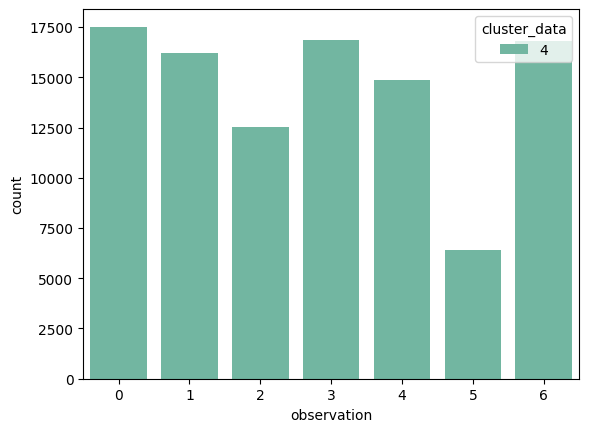

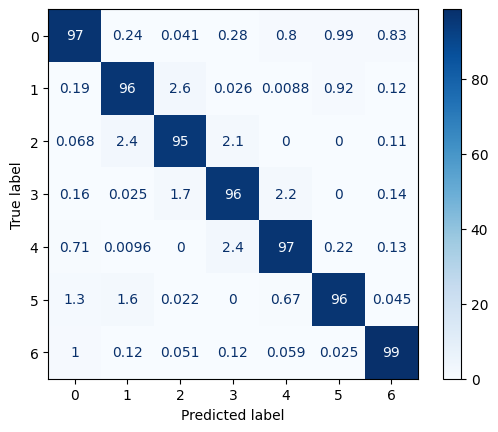

{'average_accuracy': 0.9604413702239789, 'average_f1_macro': np.float64(0.9586642031866375), 'average_f1_micro': np.float64(0.9604413702239789), 'average_auc': np.float64(0.9986155556961837), 'average_acc_kelas_generatif': 0.946243961276226, 'average_acc_fase_padi': 0.9521053791887125}
{'val_accuracy': 0.9659241692781119, 'val_f1_macro': np.float64(0.9642131913268436), 'val_f1_micro': np.float64(0.9659241692781119), 'val_auc': np.float64(0.9989803287951897), 'val_acc_kelas_generatif': 0.9580721666949009, 'val_acc_fase_padi': 0.9598686696900982, 'val_relative_acc': np.float64(99.9806746687853)}
CLUSTER:  5


[I 2024-10-23 12:05:18,626] A new study created in memory with name: no-name-8eaa513a-049c-45a2-80a8-2e0caf617f56


[6 1 2 3 5 4 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 12:05:52,297] Trial 0 finished with value: 0.9418191412993177 and parameters: {'max_depth': 8, 'learning_rate': 0.055659163492284336, 'reg_lambda': 3.136934253040033, 'min_child_weight': 84}. Best is trial 0 with value: 0.9418191412993177.


[I 2024-10-23 12:06:19,802] Trial 1 finished with value: 0.9412340779265219 and parameters: {'max_depth': 9, 'learning_rate': 0.07229061324224728, 'reg_lambda': 2.0438996095171316, 'min_child_weight': 79}. Best is trial 0 with value: 0.9418191412993177.


[I 2024-10-23 12:06:50,610] Trial 2 finished with value: 0.9426610720833012 and parameters: {'max_depth': 9, 'learning_rate': 0.06485155459100103, 'reg_lambda': 4.779073494624765, 'min_child_weight': 60}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:07:45,066] Trial 3 finished with value: 0.9419732399536406 and parameters: {'max_depth': 7, 'learning_rate': 0.03830407930956869, 'reg_lambda': 0.4166838892043966, 'min_child_weight': 83}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:08:29,216] Trial 4 finished with value: 0.9412005333628958 and parameters: {'max_depth': 6, 'learning_rate': 0.052589113986516105, 'reg_lambda': 1.527190421137445, 'min_child_weight': 100}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:09:07,669] Trial 5 finished with value: 0.9417086284197262 and parameters: {'max_depth': 7, 'learning_rate': 0.05264010593191535, 'reg_lambda': 4.689487258486727, 'min_child_weight': 57}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:09:37,674] Trial 6 finished with value: 0.9423767599645784 and parameters: {'max_depth': 8, 'learning_rate': 0.06717157867752148, 'reg_lambda': 1.9499363229237339, 'min_child_weight': 50}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:10:01,716] Trial 7 finished with value: 0.9419284036762031 and parameters: {'max_depth': 7, 'learning_rate': 0.09605027068189219, 'reg_lambda': 2.266330904836833, 'min_child_weight': 92}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:10:55,840] Trial 8 finished with value: 0.9417188878778577 and parameters: {'max_depth': 6, 'learning_rate': 0.0413860098430675, 'reg_lambda': 4.54339816480473, 'min_child_weight': 74}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:11:45,063] Trial 9 finished with value: 0.9415503573037848 and parameters: {'max_depth': 9, 'learning_rate': 0.040511710772665945, 'reg_lambda': 1.603954084738315, 'min_child_weight': 86}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:13:10,658] Trial 10 finished with value: 0.9377913555708712 and parameters: {'max_depth': 10, 'learning_rate': 0.011340649820555881, 'reg_lambda': 3.8302462362673175, 'min_child_weight': 65}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:13:36,780] Trial 11 finished with value: 0.9420621532191679 and parameters: {'max_depth': 9, 'learning_rate': 0.07877058014418237, 'reg_lambda': 3.1326566432827017, 'min_child_weight': 52}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:14:04,042] Trial 12 finished with value: 0.9419399288440257 and parameters: {'max_depth': 8, 'learning_rate': 0.07608196086605179, 'reg_lambda': 0.42508384523476295, 'min_child_weight': 63}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:14:33,326] Trial 13 finished with value: 0.9416051795883678 and parameters: {'max_depth': 10, 'learning_rate': 0.06621899856658704, 'reg_lambda': 3.0443268098068135, 'min_child_weight': 52}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:14:56,108] Trial 14 finished with value: 0.9424964485951294 and parameters: {'max_depth': 8, 'learning_rate': 0.0929228258186497, 'reg_lambda': 1.1716117050903472, 'min_child_weight': 68}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:15:17,531] Trial 15 finished with value: 0.942150933155895 and parameters: {'max_depth': 9, 'learning_rate': 0.09921341067940764, 'reg_lambda': 1.1907448866673824, 'min_child_weight': 70}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:15:41,619] Trial 16 finished with value: 0.9419761794850827 and parameters: {'max_depth': 10, 'learning_rate': 0.08530758983798573, 'reg_lambda': 0.9064368663672755, 'min_child_weight': 62}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:16:05,336] Trial 17 finished with value: 0.941998499581464 and parameters: {'max_depth': 9, 'learning_rate': 0.08750418190014572, 'reg_lambda': 4.106261579438234, 'min_child_weight': 70}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:17:13,132] Trial 18 finished with value: 0.9409882113321105 and parameters: {'max_depth': 8, 'learning_rate': 0.02328431082413443, 'reg_lambda': 2.492424727017397, 'min_child_weight': 60}. Best is trial 2 with value: 0.9426610720833012.


[I 2024-10-23 12:17:35,485] Trial 19 finished with value: 0.9410382399416188 and parameters: {'max_depth': 8, 'learning_rate': 0.08668741187126629, 'reg_lambda': 3.696562745957838, 'min_child_weight': 70}. Best is trial 2 with value: 0.9426610720833012.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.06485155459100103, 'reg_lambda': 4.779073494624765, 'min_child_weight': 60}
Best Score: 0.9426610720833012
Start the modelling
[0]	train-mlogloss:1.77314	eval-mlogloss:1.78067


[100]	train-mlogloss:0.08421	eval-mlogloss:0.20177


[200]	train-mlogloss:0.03546	eval-mlogloss:0.17179


[300]	train-mlogloss:0.02026	eval-mlogloss:0.16641


[400]	train-mlogloss:0.01408	eval-mlogloss:0.16668


[500]	train-mlogloss:0.01092	eval-mlogloss:0.16776


[600]	train-mlogloss:0.00904	eval-mlogloss:0.16893


[700]	train-mlogloss:0.00782	eval-mlogloss:0.17060


[800]	train-mlogloss:0.00696	eval-mlogloss:0.17197


[900]	train-mlogloss:0.00634	eval-mlogloss:0.17340


[1000]	train-mlogloss:0.00584	eval-mlogloss:0.17439


[1100]	train-mlogloss:0.00545	eval-mlogloss:0.17542


[1200]	train-mlogloss:0.00512	eval-mlogloss:0.17615


[1300]	train-mlogloss:0.00485	eval-mlogloss:0.17710


[1361]	train-mlogloss:0.00471	eval-mlogloss:0.17761


[0]	train-mlogloss:1.77227	eval-mlogloss:1.78230


[100]	train-mlogloss:0.08112	eval-mlogloss:0.20621


[200]	train-mlogloss:0.03472	eval-mlogloss:0.17333


[300]	train-mlogloss:0.02016	eval-mlogloss:0.16640


[400]	train-mlogloss:0.01413	eval-mlogloss:0.16484


[500]	train-mlogloss:0.01102	eval-mlogloss:0.16555


[600]	train-mlogloss:0.00913	eval-mlogloss:0.16622


[700]	train-mlogloss:0.00790	eval-mlogloss:0.16702


[800]	train-mlogloss:0.00704	eval-mlogloss:0.16789


[900]	train-mlogloss:0.00640	eval-mlogloss:0.16887


[1000]	train-mlogloss:0.00590	eval-mlogloss:0.16975


[1100]	train-mlogloss:0.00549	eval-mlogloss:0.17040


[1200]	train-mlogloss:0.00515	eval-mlogloss:0.17124


[1300]	train-mlogloss:0.00488	eval-mlogloss:0.17208


[1400]	train-mlogloss:0.00465	eval-mlogloss:0.17272


[1436]	train-mlogloss:0.00457	eval-mlogloss:0.17300


[0]	train-mlogloss:1.77228	eval-mlogloss:1.78217


[100]	train-mlogloss:0.08383	eval-mlogloss:0.20322


[200]	train-mlogloss:0.03505	eval-mlogloss:0.16869


[300]	train-mlogloss:0.02022	eval-mlogloss:0.16201


[400]	train-mlogloss:0.01415	eval-mlogloss:0.16058


[500]	train-mlogloss:0.01101	eval-mlogloss:0.16099


[600]	train-mlogloss:0.00910	eval-mlogloss:0.16174


[700]	train-mlogloss:0.00786	eval-mlogloss:0.16268


[800]	train-mlogloss:0.00699	eval-mlogloss:0.16375


[900]	train-mlogloss:0.00635	eval-mlogloss:0.16479


[1000]	train-mlogloss:0.00586	eval-mlogloss:0.16564


[1100]	train-mlogloss:0.00547	eval-mlogloss:0.16645


[1200]	train-mlogloss:0.00514	eval-mlogloss:0.16732


[1300]	train-mlogloss:0.00487	eval-mlogloss:0.16814


[1400]	train-mlogloss:0.00464	eval-mlogloss:0.16888


[1410]	train-mlogloss:0.00462	eval-mlogloss:0.16892


[0]	train-mlogloss:1.77035	eval-mlogloss:1.77848


[50]	train-mlogloss:0.19407	eval-mlogloss:0.28768


[100]	train-mlogloss:0.08532	eval-mlogloss:0.19204


[150]	train-mlogloss:0.05494	eval-mlogloss:0.16998


[200]	train-mlogloss:0.03845	eval-mlogloss:0.16069


[250]	train-mlogloss:0.02829	eval-mlogloss:0.15589


[300]	train-mlogloss:0.02173	eval-mlogloss:0.15370


[350]	train-mlogloss:0.01755	eval-mlogloss:0.15278


[400]	train-mlogloss:0.01464	eval-mlogloss:0.15266


[430]	train-mlogloss:0.01337	eval-mlogloss:0.15279



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     13230
           1       0.95      0.94      0.94     12299
           2       0.93      0.94      0.93     11894
           3       0.94      0.92      0.93     12788
           4       0.93      0.95      0.94     12367
           5       0.92      0.95      0.93      9640
           6       0.99      0.99      0.99      7335

    accuracy                           0.94     79553
   macro avg       0.95      0.95      0.95     79553
weighted avg       0.94      0.94      0.94     79553



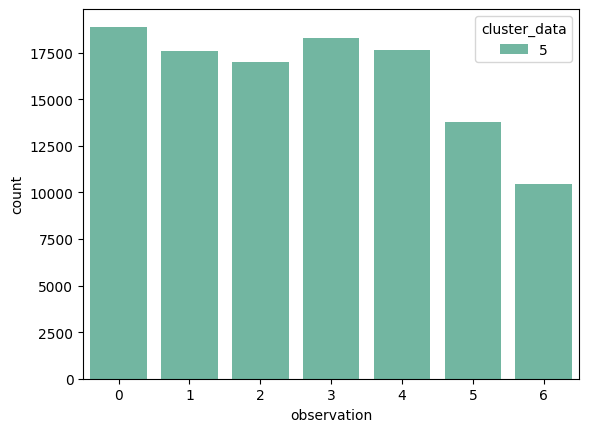

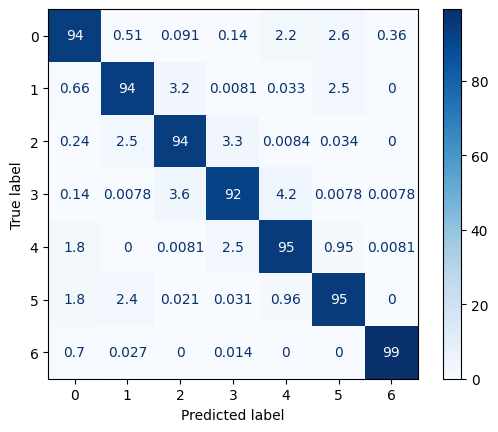

{'average_accuracy': 0.9411902468923018, 'average_f1_macro': np.float64(0.9438352218322176), 'average_f1_micro': np.float64(0.9411902468923018), 'average_auc': np.float64(0.9973025460123964), 'average_acc_kelas_generatif': 0.9191601455830787, 'average_acc_fase_padi': 0.9320030237510006}
{'val_accuracy': 0.9431448216911996, 'val_f1_macro': np.float64(0.9457415566970456), 'val_f1_micro': np.float64(0.9431448216911996), 'val_auc': np.float64(0.9975818321575735), 'val_acc_kelas_generatif': 0.9202377228651861, 'val_acc_fase_padi': 0.9355394342222583, 'val_relative_acc': np.float64(99.96921498204208)}
CLUSTER:  6


[I 2024-10-23 12:19:08,008] A new study created in memory with name: no-name-55c44989-19f5-41a4-9e74-5ff52cfa800f


[1 2 0 5 6 3 4]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-23 12:20:02,524] Trial 0 finished with value: 0.8994157381639954 and parameters: {'max_depth': 6, 'learning_rate': 0.03439798737960328, 'reg_lambda': 4.814687310504189, 'min_child_weight': 54}. Best is trial 0 with value: 0.8994157381639954.


[I 2024-10-23 12:20:53,132] Trial 1 finished with value: 0.8991418698618387 and parameters: {'max_depth': 6, 'learning_rate': 0.03599226782478897, 'reg_lambda': 2.3812005144806965, 'min_child_weight': 56}. Best is trial 0 with value: 0.8994157381639954.


[I 2024-10-23 12:21:27,616] Trial 2 finished with value: 0.9008334263023299 and parameters: {'max_depth': 10, 'learning_rate': 0.052883064790492575, 'reg_lambda': 3.402399082301691, 'min_child_weight': 86}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:22:35,914] Trial 3 finished with value: 0.899036441066355 and parameters: {'max_depth': 9, 'learning_rate': 0.02125274249917105, 'reg_lambda': 3.3695910910524685, 'min_child_weight': 54}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:23:37,081] Trial 4 finished with value: 0.8993918474715802 and parameters: {'max_depth': 10, 'learning_rate': 0.02567705683942753, 'reg_lambda': 2.5914470627333914, 'min_child_weight': 74}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:24:34,892] Trial 5 finished with value: 0.887485524656547 and parameters: {'max_depth': 6, 'learning_rate': 0.010645426766016444, 'reg_lambda': 2.4790178876727498, 'min_child_weight': 87}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:25:13,276] Trial 6 finished with value: 0.89954146299413 and parameters: {'max_depth': 10, 'learning_rate': 0.04344876629292136, 'reg_lambda': 1.0102097592824093, 'min_child_weight': 69}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:26:32,648] Trial 7 finished with value: 0.8962257695970091 and parameters: {'max_depth': 9, 'learning_rate': 0.01328097917444745, 'reg_lambda': 2.537895183884692, 'min_child_weight': 73}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:26:57,744] Trial 8 finished with value: 0.8989931977493678 and parameters: {'max_depth': 7, 'learning_rate': 0.08411141772729243, 'reg_lambda': 3.1501857385702543, 'min_child_weight': 96}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:27:52,978] Trial 9 finished with value: 0.8996266676159985 and parameters: {'max_depth': 7, 'learning_rate': 0.032662121793424044, 'reg_lambda': 1.5309982431654845, 'min_child_weight': 51}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:28:20,787] Trial 10 finished with value: 0.8992406820926329 and parameters: {'max_depth': 9, 'learning_rate': 0.06905318613667685, 'reg_lambda': 4.45938008993392, 'min_child_weight': 86}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:28:53,950] Trial 11 finished with value: 0.9002353512330914 and parameters: {'max_depth': 8, 'learning_rate': 0.056369503594967, 'reg_lambda': 0.8268265818792179, 'min_child_weight': 85}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:29:25,427] Trial 12 finished with value: 0.8997551414025576 and parameters: {'max_depth': 8, 'learning_rate': 0.05829575427074727, 'reg_lambda': 0.6627276781254876, 'min_child_weight': 85}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:29:55,880] Trial 13 finished with value: 0.8977406464690966 and parameters: {'max_depth': 8, 'learning_rate': 0.05914622479451304, 'reg_lambda': 0.1875599683613074, 'min_child_weight': 99}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:30:16,937] Trial 14 finished with value: 0.9001136046432762 and parameters: {'max_depth': 7, 'learning_rate': 0.09916509314204064, 'reg_lambda': 3.6383560560302017, 'min_child_weight': 81}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:30:42,361] Trial 15 finished with value: 0.8988493816667565 and parameters: {'max_depth': 9, 'learning_rate': 0.0721197178737279, 'reg_lambda': 1.5967924719086068, 'min_child_weight': 93}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:31:18,026] Trial 16 finished with value: 0.9002910653862238 and parameters: {'max_depth': 10, 'learning_rate': 0.04738029463685311, 'reg_lambda': 3.9560353911644306, 'min_child_weight': 63}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:31:54,304] Trial 17 finished with value: 0.8997878334117567 and parameters: {'max_depth': 10, 'learning_rate': 0.046618271311382416, 'reg_lambda': 4.104150067384091, 'min_child_weight': 63}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:32:30,094] Trial 18 finished with value: 0.9001639922576494 and parameters: {'max_depth': 10, 'learning_rate': 0.04589711185644137, 'reg_lambda': 3.89693562303137, 'min_child_weight': 64}. Best is trial 2 with value: 0.9008334263023299.


[I 2024-10-23 12:32:55,064] Trial 19 finished with value: 0.9000968464054537 and parameters: {'max_depth': 10, 'learning_rate': 0.06807191064503823, 'reg_lambda': 3.0642982710685724, 'min_child_weight': 63}. Best is trial 2 with value: 0.9008334263023299.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.052883064790492575, 'reg_lambda': 3.402399082301691, 'min_child_weight': 86}
Best Score: 0.9008334263023299
Start the modelling
[0]	train-mlogloss:1.81393	eval-mlogloss:1.81956


[100]	train-mlogloss:0.15857	eval-mlogloss:0.29728


[200]	train-mlogloss:0.08540	eval-mlogloss:0.26109


[300]	train-mlogloss:0.05348	eval-mlogloss:0.25283


[400]	train-mlogloss:0.03751	eval-mlogloss:0.25214


[500]	train-mlogloss:0.02867	eval-mlogloss:0.25408


[600]	train-mlogloss:0.02325	eval-mlogloss:0.25647


[700]	train-mlogloss:0.01961	eval-mlogloss:0.25907


[800]	train-mlogloss:0.01706	eval-mlogloss:0.26151


[900]	train-mlogloss:0.01520	eval-mlogloss:0.26367


[1000]	train-mlogloss:0.01377	eval-mlogloss:0.26579


[1100]	train-mlogloss:0.01265	eval-mlogloss:0.26765


[1200]	train-mlogloss:0.01174	eval-mlogloss:0.26946


[1300]	train-mlogloss:0.01098	eval-mlogloss:0.27097


[1390]	train-mlogloss:0.01041	eval-mlogloss:0.27240


[0]	train-mlogloss:1.81327	eval-mlogloss:1.81881


[100]	train-mlogloss:0.16161	eval-mlogloss:0.29487


[200]	train-mlogloss:0.08785	eval-mlogloss:0.25798


[300]	train-mlogloss:0.05514	eval-mlogloss:0.24994


[400]	train-mlogloss:0.03857	eval-mlogloss:0.24915


[500]	train-mlogloss:0.02932	eval-mlogloss:0.25036


[600]	train-mlogloss:0.02365	eval-mlogloss:0.25257


[700]	train-mlogloss:0.01993	eval-mlogloss:0.25488


[800]	train-mlogloss:0.01733	eval-mlogloss:0.25704


[900]	train-mlogloss:0.01540	eval-mlogloss:0.25925


[1000]	train-mlogloss:0.01394	eval-mlogloss:0.26138


[1100]	train-mlogloss:0.01280	eval-mlogloss:0.26348


[1200]	train-mlogloss:0.01187	eval-mlogloss:0.26489


[1300]	train-mlogloss:0.01112	eval-mlogloss:0.26663


[1400]	train-mlogloss:0.01047	eval-mlogloss:0.26806


[1408]	train-mlogloss:0.01042	eval-mlogloss:0.26815


[0]	train-mlogloss:1.81384	eval-mlogloss:1.81988


[100]	train-mlogloss:0.15694	eval-mlogloss:0.30459


[200]	train-mlogloss:0.08201	eval-mlogloss:0.26969


[300]	train-mlogloss:0.05095	eval-mlogloss:0.26248


[400]	train-mlogloss:0.03549	eval-mlogloss:0.26255


[500]	train-mlogloss:0.02725	eval-mlogloss:0.26524


[600]	train-mlogloss:0.02210	eval-mlogloss:0.26813


[700]	train-mlogloss:0.01873	eval-mlogloss:0.27116


[800]	train-mlogloss:0.01635	eval-mlogloss:0.27415


[900]	train-mlogloss:0.01463	eval-mlogloss:0.27669


[1000]	train-mlogloss:0.01330	eval-mlogloss:0.27918


[1100]	train-mlogloss:0.01225	eval-mlogloss:0.28167


[1200]	train-mlogloss:0.01140	eval-mlogloss:0.28372


[1300]	train-mlogloss:0.01070	eval-mlogloss:0.28553


[1374]	train-mlogloss:0.01025	eval-mlogloss:0.28674


[0]	train-mlogloss:1.81140	eval-mlogloss:1.81621


[50]	train-mlogloss:0.31656	eval-mlogloss:0.40750


[100]	train-mlogloss:0.16265	eval-mlogloss:0.28211


[150]	train-mlogloss:0.12060	eval-mlogloss:0.25497


[200]	train-mlogloss:0.09547	eval-mlogloss:0.24356


[250]	train-mlogloss:0.07512	eval-mlogloss:0.23587


[300]	train-mlogloss:0.06083	eval-mlogloss:0.23166


[350]	train-mlogloss:0.05065	eval-mlogloss:0.22933


[400]	train-mlogloss:0.04283	eval-mlogloss:0.22800


[450]	train-mlogloss:0.03688	eval-mlogloss:0.22759


[500]	train-mlogloss:0.03221	eval-mlogloss:0.22765


[526]	train-mlogloss:0.03014	eval-mlogloss:0.22784



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     12654
           1       0.92      0.91      0.92     12873
           2       0.91      0.93      0.92     12925
           3       0.92      0.92      0.92     13285
           4       0.92      0.93      0.93     12833
           5       0.92      0.93      0.92     11875
           6       0.88      0.80      0.84      5186

    accuracy                           0.92     81631
   macro avg       0.91      0.91      0.91     81631
weighted avg       0.92      0.92      0.91     81631



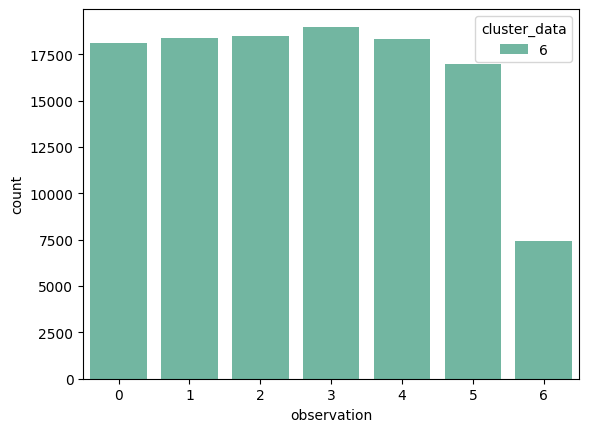

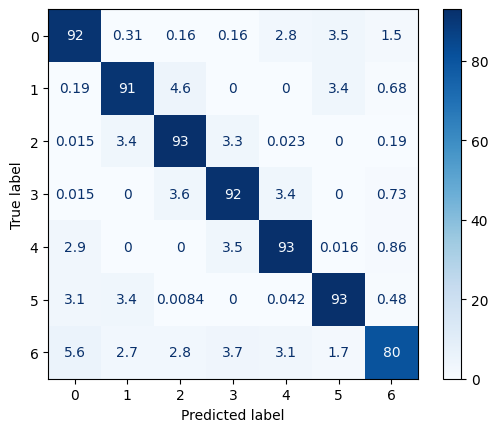

{'average_accuracy': 0.9091298763615852, 'average_f1_macro': np.float64(0.9025267056362724), 'average_f1_micro': np.float64(0.9091298763615852), 'average_auc': np.float64(0.9915772728692825), 'average_acc_kelas_generatif': 0.9151593322345989, 'average_acc_fase_padi': 0.9170748577194475}
{'val_accuracy': 0.9151915326285357, 'val_f1_macro': np.float64(0.9087174144890395), 'val_f1_micro': np.float64(0.9151915326285357), 'val_auc': np.float64(0.9937376786682083), 'val_acc_kelas_generatif': 0.9223936770794129, 'val_acc_fase_padi': 0.9227983665921874, 'val_relative_acc': np.float64(99.99361471170424)}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [11]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)